# Code Lab 4C - Transfer Learning in NLP

## Fine-tuning ELMo for Text Classification

In this Code Lab, we are going to make use of a pre-trained ELMo model from [TensorFlow Hub](https://www.tensorflow.org/hub/). ELMo is a model that makes use of a **language model** (a more complex representation compared to work embeddings) to achieve state of the art results (until recently, but that's how fast things are moving.

**More on ELMo**

* https://allennlp.org/elmo
* [ArXiv: Deep contextualized word representations](https://arxiv.org/abs/1802.05365)

This notebook consist of 4 main sections:

1. Preparing the data
2. Implementing a simple CNN model
3. Training the model
4. Evaluating the model

**Key Model Parameters**

In [1]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 20 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.3   # data for validation (not used in training)

In [2]:
import numpy as np
import re, sys, csv, pickle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow_hub as hub

from keras import regularizers, initializers, optimizers, callbacks
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


### 1. Prepare the data

**Preprocessing Step**

Removing [stopwords](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), punctuation and making everything lowercase.

In [3]:
from nltk.corpus import stopwords
def clean_text(text, remove_stopwords=True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

**Reading from Dataset**

In [4]:
texts = []   # empty list for model input: the movie reviews
labels = []  # empty lists model output: sentiment labels

data_neg = open("datasets/stanford_movie_neg.txt", "rb") 
for line in tqdm_notebook(data_neg, total=5331): 
    texts.append(clean_text(line, remove_stopwords=False))
    labels.append(int(0))

In [5]:
data_pos = open("datasets/stanford_movie_pos.txt", "rb") 
for line in tqdm_notebook(data_pos, total=5331): 
    texts.append(clean_text(line, remove_stopwords=False))
    labels.append(int(1))

In [6]:
print("Sample positive:", texts[0], labels[0])
print("Sample negative:", texts[9000], labels[9000])

Sample positive: simplistic silly and tedious 0
Sample negative: with few respites marshall keeps the energy humming and his edits unlike those in moulin rouge are crisp and purposeful without overdoing it 1


**Generate the array of sentences from dataset**

In [7]:
all_text = [' '.join(t.split()[0:150]) for t in texts]
all_text = np.array(all_text, dtype=object)[:, np.newaxis]

labels = to_categorical(np.asarray(labels)) # convert the category label to one-hot encoding
print('[i] Shape of data tensor:', all_text.shape)
print('[i] Shape of label tensor:', labels.shape)

indices = np.arange(all_text.shape[0])
np.random.shuffle(indices)
all_text = all_text[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * all_text.shape[0])
x_train = all_text[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = all_text[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:",y_train.sum(axis=0))
print("[+] Validation:",y_val.sum(axis=0))

[i] Shape of data tensor: (10662, 1)
[i] Shape of label tensor: (10662, 2)
[i] Number of entries in each category:
[+] Training: [3743. 3721.]
[+] Validation: [1588. 1610.]


**What does the data look like?**

In [8]:
print("Sentence input", all_text[0])
print("")
print("One-hot label", labels[0])

Sentence input ['grows decidedly flimsier with its many outsized out of character and logically porous action set pieces']

One-hot label [1. 0.]


### 2. Create the model

We will now start to create the model in `Keras`.

**Create the `ELMo` layer**

Computes deep contextualized word representations using character-based word representations and bidirectional LSTMs. Paper: [Deep contextualized word representations](https://arxiv.org/abs/1802.05365)

In [9]:
# Initialize session
sess = tf.Session()
K.set_session(sess)

In [10]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


**Rest of the model**

In [11]:
sequence_input = Input(shape=(1,), dtype=tf.string)
embedded_sequences = Lambda(ElmoEmbedding, output_shape=(1024,))(sequence_input)
embedded_sequences = Reshape((1024, 1,))(embedded_sequences)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
l_drop = Dropout(0.5)(embedded_sequences)
l_flat = Flatten()(l_drop)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense) #follows the number of classes

**Compile the model into a static graph for training**

In [13]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024, 1)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total para

**Visualisation**

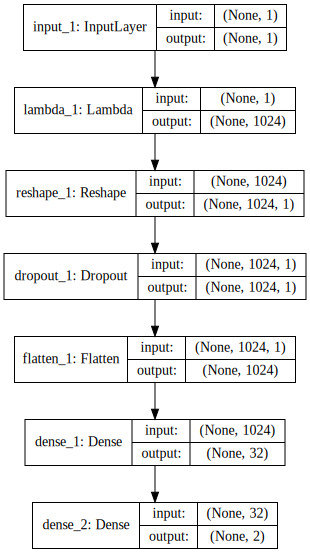

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 3. Train the model

In [15]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                               epochs=15, batch_size=64)

Training Progress:
Train on 7464 samples, validate on 3198 samples
Epoch 1/15
7464/7464 [==============================] - 108s 15ms/step - loss: 0.5907 - acc: 0.6853 - val_loss: 0.4839 - val_acc: 0.7661
Epoch 2/15
7464/7464 [==============================] - 100s 13ms/step - loss: 0.5261 - acc: 0.7390 - val_loss: 0.4778 - val_acc: 0.7645
Epoch 3/15
7464/7464 [==============================] - 101s 13ms/step - loss: 0.5093 - acc: 0.7450 - val_loss: 0.4493 - val_acc: 0.7833
Epoch 4/15
7464/7464 [==============================] - 101s 13ms/step - loss: 0.5053 - acc: 0.7527 - val_loss: 0.4780 - val_acc: 0.7617
Epoch 5/15
7464/7464 [==============================] - 100s 13ms/step - loss: 0.4907 - acc: 0.7515 - val_loss: 0.4469 - val_acc: 0.7871
Epoch 7/15
7464/7464 [==============================] - 100s 13ms/step - loss: 0.4851 - acc: 0.7618 - val_loss: 0.4528 - val_acc: 0.7817
Epoch 8/15
7464/7464 [==============================] - 100s 13ms/step - loss: 0.4880 - acc: 0.7627 - val_loss:

### 4. Evaluate the model

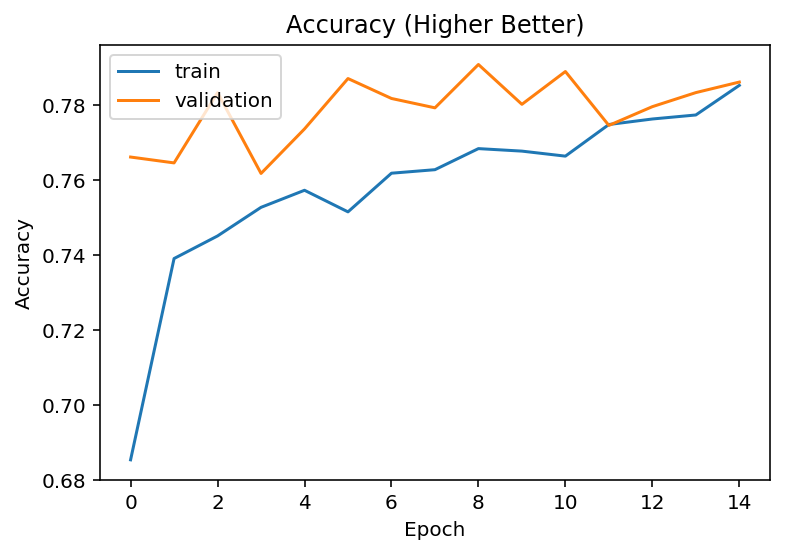

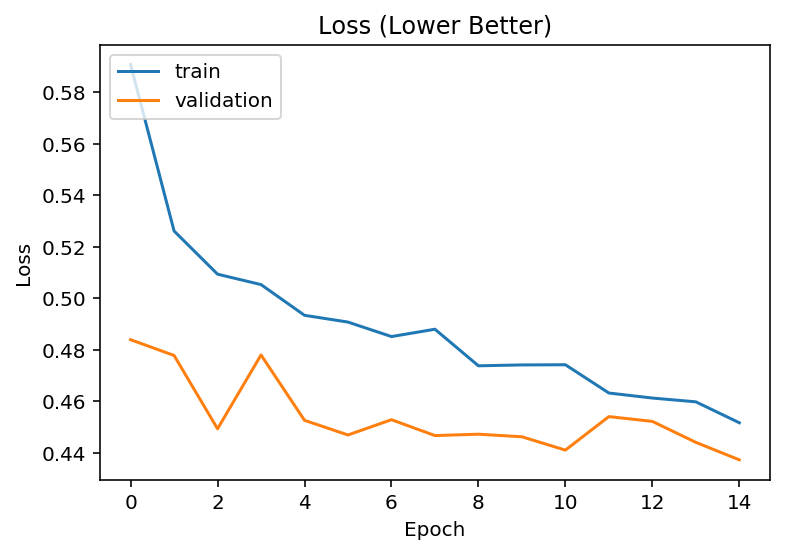

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

classes = ["positive", "negative"]

In [18]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    positive       0.77      0.81      0.79      1588
    negative       0.80      0.76      0.78      1610

   micro avg       0.79      0.79      0.79      3198
   macro avg       0.79      0.79      0.79      3198
weighted avg       0.79      0.79      0.79      3198



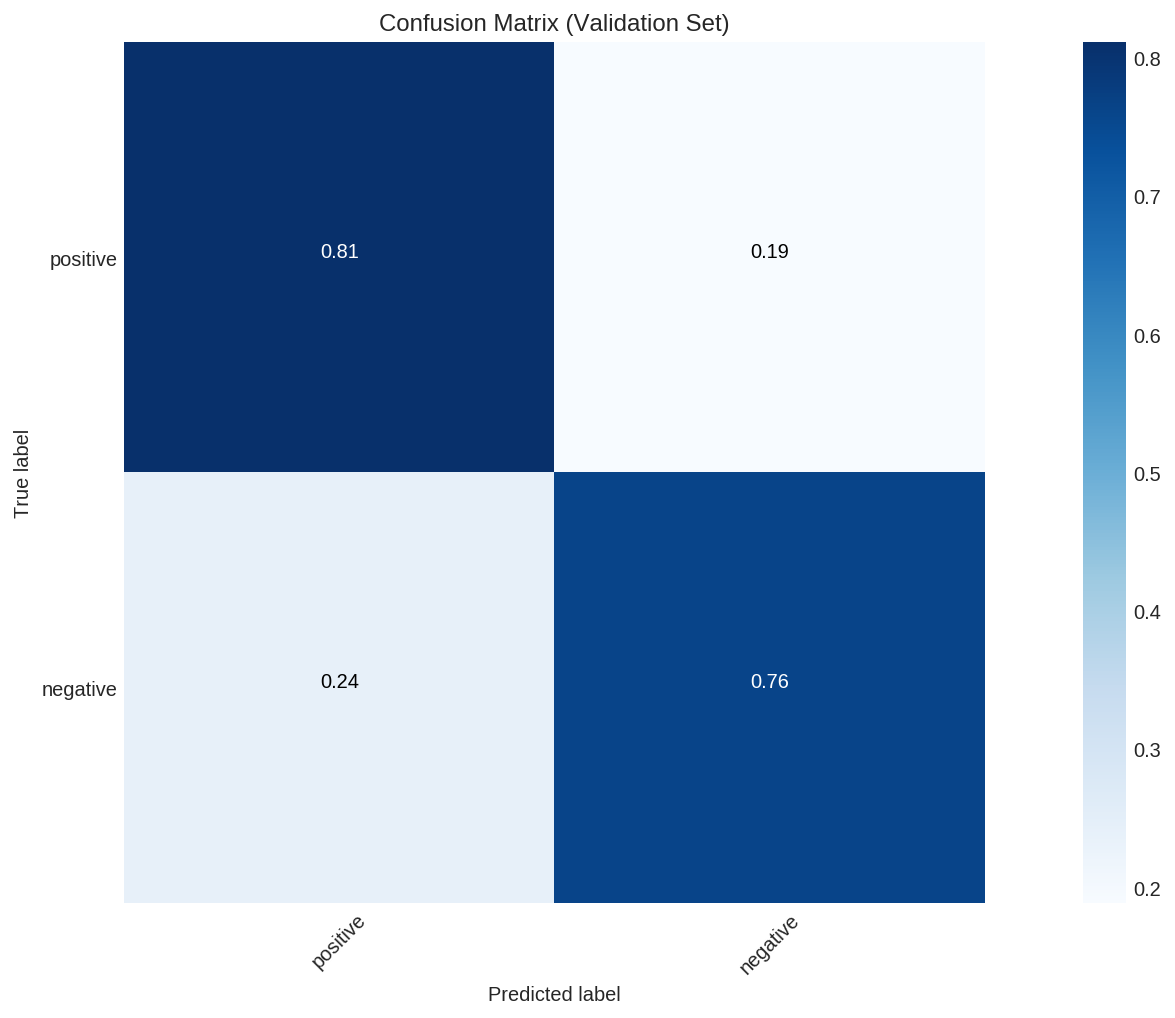

In [19]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)